In [1]:
# Importing all the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pickle
from tensorflow import saved_model
import re
import tensorflow
from nltk.corpus import stopwords
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.math import reduce_mean

In [2]:
# Importing dataset
data = pd.read_json('Sarcasm_Headlines_Dataset.json', lines=True)
data.head(5)

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


In [3]:
# Dropping the article link column
data.drop(['article_link'],inplace = True,axis =1)
data.head(5)

,is_sarcastic,headline
0,1,thirtysomething scientists unveil doomsday clo...
1,0,dem rep. totally nails why congress is falling...
2,0,eat your veggies: 9 deliciously different recipes
3,1,inclement weather prevents liar from getting t...
4,1,mother comes pretty close to using word 'strea...


C:\Users\kalpe\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='is_sarcastic', ylabel='count'>

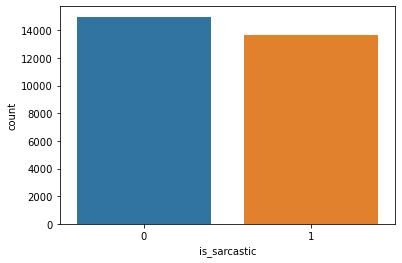

In [4]:
# Class balance
sns.countplot(data['is_sarcastic'])

In [5]:
print('Non Sarcastic : {0} %'.format((data['is_sarcastic'].value_counts()[0]/(data['is_sarcastic'].value_counts()[0] + data['is_sarcastic'].value_counts()[1] ))* 100))
print('Sarcastic : {0} %'.format((data['is_sarcastic'].value_counts()[1]/(data['is_sarcastic'].value_counts()[0] + data['is_sarcastic'].value_counts()[1] ))* 100))

Non Sarcastic : 52.360320067088296 %
Sarcastic : 47.6396799329117 %


In [6]:
def f_word_cloud(column):
    
    comment_words = ' '
    stopwords = set(STOPWORDS)

    # iterate through the csv file 
    for val in column: 

        # typecaste each val to string 
        val = str(val) 

        # split the value 
        tokens = val.split() 

        # Converts each token into lowercase 
        for i in range(len(tokens)):
            tokens[i] = tokens[i].lower() 

        for words in tokens: 
            comment_words = comment_words + words + ' '


    wordcloud = WordCloud(width = 800, height = 800, 
                    background_color ='white', 
                    min_font_size = 10).generate(comment_words) 
    
    return wordcloud


The non sarcastic class is more than sarcastic class. But there is acceptable class imbalance.

In [7]:
# length of the sentence
print(data['headline'][2])
print('Length of the sentence is : {0}'.format(len(data['headline'][2].split(' '))))

max_length = 0
for i in range(data.shape[0]):
    temp = len(data['headline'][i].split(' '))
    if temp > max_length:
        max_length = temp
print('Maximum Length of a headline in data set is : {0}'.format(max_length))

eat your veggies: 9 deliciously different recipes
Length of the sentence is : 7
Maximum Length of a headline in data set is : 151


In [8]:
print(data['headline'][7302])

hot wheels ranked number one toy for rolling down ramp, knocking over dominoes that send marble down a funnel, dropping onto teeter-totter that yanks on string, causing pulley system to raise wooden block, propelling series of twine rollers that unwind spring, launching tennis ball across room, inching tire down slope until it hits power switch, activating table fan that blows toy ship with nail attached to it across kiddie pool, popping water balloon that fills cup, weighing down lever that forces basketball down track, nudging broomstick on axis to rotate, allowing golf ball to roll into sideways coffee mug, which tumbles down row of hardcover books until handle catches hook attached to lever that causes wooden mallet to slam down on serving spoon, catapulting small ball into cup attached by ribbon to lazy susan, which spins until it pushes d battery down incline plane, tipping over salt shaker to season omelet


In [9]:
# # Removing all alpha_numeric characters
# Temp = []
# for i in range(data.shape[0]):
#     Temp.append(re.sub(r'[^a-zA-Z_\s]+','',data['headline'][i]))
# data['cleaned_headline'] = Temp

In [10]:
def format_data(text):
    text = re.sub(r'[^a-zA-Z0-9_\s]+','',text)
#     text = ' '.join([w for w in text.split() if w not in stopwords.words('english')])
    return(text)
data['cleaned_headline'] = data['headline'].apply(format_data)

In [11]:
# After removing alpha numeric characters
for i in range(5):
    print('Before: {0}'.format(data['headline'][i]))
    print('After : {0}'.format(data['cleaned_headline'][i]))
    print('\t')

Before: thirtysomething scientists unveil doomsday clock of hair loss
After : thirtysomething scientists unveil doomsday clock of hair loss
	
Before: dem rep. totally nails why congress is falling short on gender, racial equality
After : dem rep totally nails why congress is falling short on gender racial equality
	
Before: eat your veggies: 9 deliciously different recipes
After : eat your veggies 9 deliciously different recipes
	
Before: inclement weather prevents liar from getting to work
After : inclement weather prevents liar from getting to work
	
Before: mother comes pretty close to using word 'streaming' correctly
After : mother comes pretty close to using word streaming correctly
	


### Parmeters

In [12]:
max_length_of_headline = 50
num_words = 10000
Embedding_dimension = 50
lstm_out = 50

### Train Test Split

In [13]:
# Features
X = data['cleaned_headline'].values

# labels
Y = data['is_sarcastic'].values
Y = to_categorical(Y,num_classes=2)

In [14]:
x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size = 0.3,stratify = Y,random_state = 123)

### Word Tokenizing and GLove Embedding

In [15]:
# Tokenizing the text
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(x_train)

filename = 'tokenizer.pickle'
pickle.dump(tokenizer, open(filename, 'wb'), protocol=pickle.HIGHEST_PROTOCOL)

In [16]:
# Word_index_vector 
words_to_index = tokenizer.word_index

In [17]:
Vocab_length = len(tokenizer.word_index)
print('The Vocabulary of the text is : {0}'.format(Vocab_length))

The Vocabulary of the text is : 24809


In [18]:
# Function for loading and reading GLove Embeddings
def read_glove_vector(glove_vec):
    with open(glove_vec, 'r', encoding='UTF-8') as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            w_line = line.split()
            curr_word = w_line[0]
            word_to_vec_map[curr_word] = np.array(w_line[1:], dtype=np.float64)
    return word_to_vec_map

In [19]:
# GLove Embedding vector
word_to_glove_map = read_glove_vector('glove.6B.50d.txt')

In [20]:
# Creating Embedding Matrix 
Emb_matrix = np.zeros((Vocab_length+1,Embedding_dimension))

for word, index in words_to_index.items():
    embedding_vector = word_to_glove_map.get(word)
    if embedding_vector is not None:
        Emb_matrix[index, :] = embedding_vector

In [21]:
Emb_matrix

array([[ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.68047 , -0.039263,  0.30186 , ..., -0.073297, -0.064699,
        -0.26044 ],
       [ 0.70853 ,  0.57088 , -0.4716  , ..., -0.22562 , -0.093918,
        -0.80375 ],
       ...,
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.51888 , -0.35872 ,  0.24872 , ...,  0.59534 , -0.17319 ,
        -0.24333 ],
       [-0.40886 ,  0.64601 , -0.44272 , ...,  0.32651 , -0.18354 ,
         0.031975]])

### Features and labels

In [43]:
x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)

In [124]:
x_train = pad_sequences(x_train,maxlen=50,padding='post',value=0)
x_test = pad_sequences(x_test,maxlen=50,padding='post',value=0)

### Model

In [27]:
# Building model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout,Bidirectional,Input

Input = Input(shape = (50,))
embeding = Embedding(Vocab_length+1, Embedding_dimension, input_length= max_length_of_headline,weights = [Emb_matrix], trainable=True)(Input)
dropout = Dropout(0.2)(embeding)
lstm = Bidirectional(LSTM(lstm_out, recurrent_dropout=0.2))(dropout)
hidden_dense = Dense(10,activation ='relu')(lstm)
output = Dense(2,activation='softmax')(hidden_dense)

model = Model(inputs = Input,outputs =output)

In [28]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 50, 50)            1240500   
_________________________________________________________________
dropout (Dropout)            (None, 50, 50)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 100)               40400     
_________________________________________________________________
dense (Dense)                (None, 10)                1010      
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 22        
Total params: 1,281,932
Trainable params: 1,281,932
Non-trainable params: 0
___________________________________________________

In [30]:
# Optimizer
Optimizer = tensorflow.keras.optimizers.Adam(learning_rate = 1e-4,beta_1 = 0.99,decay = 1e-5)

# Compile Model
model.compile(loss = 'categorical_crossentropy', optimizer=Optimizer,metrics = ['accuracy'])

In [31]:
# Defining Callbacks
EarlyStopping = tensorflow.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=4,min_delta = 0.01)

ModelCheckpoint = tensorflow.keras.callbacks.ModelCheckpoint("Proj_2_model-{val_loss:.2f}.h5",monitor='loss',save_best_only= True,save_weights_only=True)

reduceLoss = tensorflow.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.01,patience=2, min_lr=0.00001)

In [129]:
model.fit(x_train, y_train, epochs = 20 , batch_size= 32,  validation_data=(x_test,y_test),callbacks = [EarlyStopping,reduceLoss,ModelCheckpoint])

Epoch 1/20
627/627 [==============================] - 32s 48ms/step - loss: 0.6662 - accuracy: 0.6047 - val_loss: 0.6234 - val_accuracy: 0.6783
Epoch 2/20
627/627 [==============================] - 30s 48ms/step - loss: 0.5759 - accuracy: 0.7074 - val_loss: 0.5252 - val_accuracy: 0.7449
Epoch 3/20
627/627 [==============================] - 33s 53ms/step - loss: 0.5077 - accuracy: 0.7498 - val_loss: 0.4742 - val_accuracy: 0.7764
Epoch 4/20
627/627 [==============================] - 31s 49ms/step - loss: 0.4616 - accuracy: 0.7814 - val_loss: 0.4368 - val_accuracy: 0.8010
Epoch 5/20
627/627 [==============================] - 29s 46ms/step - loss: 0.4297 - accuracy: 0.8024 - val_loss: 0.4117 - val_accuracy: 0.8178
Epoch 6/20
627/627 [==============================] - 28s 45ms/step - loss: 0.4121 - accuracy: 0.8133 - val_loss: 0.3936 - val_accuracy: 0.8261
Epoch 7/20
627/627 [==============================] - 29s 46ms/step - loss: 0.3857 - accuracy: 0.8262 - val_loss: 0.3789 - val_accuracy:

In [32]:
# Selecting the best model
Final_model = Model(inputs = Input,outputs =output)
Final_model.load_weights('Proj_2_model-0.33.h5')
Final_model.compile(loss = 'categorical_crossentropy', optimizer=Optimizer,metrics = ['accuracy'])

In [51]:
# Accuracy and Loss
score,acc = Final_model.evaluate(x_test, y_test, verbose = 2, batch_size = 32)

print("Loss on Test Data : %.2f" % (score))
print("Accuracy on test Data : %.2f" % (acc))

269/269 - 2s - loss: 0.3279 - accuracy: 0.8576
Loss on Test Data : 0.33
Accuracy on test Data : 0.86


In [131]:
i = 11016
# Test sentence
Test_sentence = data['cleaned_headline'][i]
print('Sentence : "{0}""'.format(Test_sentence))

# converting the sentence to sequence
Test = tokenizer.texts_to_sequences([Test_sentence])
Test = pad_sequences(Test,maxlen=50,padding='post',value =0)

# Predicting
result = Final_model.predict(Test)[0]

if np.argmax(result) == 1:
    print("Model Prediction : The headline is Sarcastic")
else:
    print('Model Prediction : The headline is not Sarcastic')

if data['is_sarcastic'][i] == 1:
    print("Truth Value      : The headline is Sarcastic")
else:
    print('Truth Value      : The headline is not Sarcastic')
    
if np.argmax(result) == data['is_sarcastic'][i]:
    print('Correct Prediction !!!')
else:
    print('Wrong Prediction !!!')


Sentence : "undecided debate viewer waiting until he hears same responses for seventh time before making decision""
Model Prediction : The headline is Sarcastic
Truth Value      : The headline is Sarcastic
Correct Prediction !!!


In [34]:
Final_model.predict(Test)

array([[6.1451935e-04, 9.9938548e-01]], dtype=float32)

In [92]:
from tensorflow.keras.models import save_model

In [146]:
save_model(model,'model')

INFO:tensorflow:Assets written to: model\assets
